<h1>EDA</h1>

In [ ]:
%pip install mplfinance
%pip install ta
%pip install seaborn
%pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import math
from ta.trend import ema_indicator, macd, macd_signal
from ta.momentum import rsi
from ta.volatility import bollinger_hband, bollinger_lband
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import uts
import random
from consts import *

utils = uts.Utilities(is_test=uts.IS_TEST, test_num=uts.TEST_NUM)
etf_dfs = utils.get_dataframes('data/ETFs')
stock_dfs = utils.get_dataframes('data/Stocks') 


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
class BasicInfo:
    def __init__(self, dfs):
        self.dfs = dfs

    def top_n_most_traded(self, n):
        volume_stats = []

        for df in self.dfs:
            avg_volume = round(df['Volume'].mean())
            volume_stats.append({'ticker': df.name, 'avg_volume': avg_volume})

        volume_df = pd.DataFrame(volume_stats)
        top_n = volume_df.sort_values('avg_volume', ascending=False).head(n)
        return top_n
    
    def __get_random_stocks(self, n):
        rstock_inds = [random.randint(0, len(self.dfs) - 1) for _ in range(n)]
        return [self.dfs[ind] for ind in rstock_inds]
    
    def plot_random_assets(self, n, ndays):
        rows = math.ceil(n / 2)

        fig, axs = plt.subplots(rows, 2, figsize=(14, 4 * rows))
        axs = axs.flatten() 

        for i, df in enumerate(self.__get_random_stocks(n)):
            ax = axs[i]

            df_plot = df.copy().tail(ndays)
            df_plot = df_plot[['Open', 'High', 'Low', 'Close', 'Volume']]

            mpf.plot(df_plot,
                type='candle',
                volume=False,
                ax=ax,
                axtitle=df.name,
                show_nontrading=False)

        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])

        plt.tight_layout()
        plt.show()
    
    def plot_common_ta_indicators(self, n, ndays):
        for dfr in self.__get_random_stocks(n):
            if len(dfr) <= ndays: continue
            df = dfr.tail(ndays).copy()
            df['EMA20'] = ema_indicator(df['Close'], window=20)
            df['EMA50'] = ema_indicator(df['Close'], window=50)
            df['MACD'] = macd(df['Close'])
            df['RSI'] = rsi(df['Close'], window=14)
            df['BB_upper'] = bollinger_hband(df['Close'])
            df['BB_lower'] = bollinger_lband(df['Close'])
            df['MACD_signal'] = macd_signal(close=df['Close'])
            
            df = df.tail(len(df) - 50)

            apds = [
                mpf.make_addplot(df['EMA20'], color='blue'),
                mpf.make_addplot(df['EMA50'], color='purple'),
                mpf.make_addplot(df['BB_upper'], color='grey'),
                mpf.make_addplot(df['BB_lower'], color='grey'),

                mpf.make_addplot(df['MACD'], panel=1, color='green', ylabel='MACD'),
                mpf.make_addplot(df['MACD_signal'], panel=1, color='red'),

                mpf.make_addplot(df['RSI'], panel=2, color='orange', ylabel='RSI')
            ]

            df.name = dfr.name

            mpf.plot(df,
                type='candle',
                volume=True,
                addplot=apds,
                panel_ratios=(4, 2, 2), 
                title=f'Candlestick with EMA, Bollinger, MACD, RSI ({df.name})',
                style='yahoo')
    
    def corr_mtx(self):
        returns_dict = {}

        for df in self.dfs:
            df.sort_values('Date', inplace=True)
            df['daily_return'] = df['Close'].pct_change()
            df.dropna(subset=['daily_return'], inplace=True)

            returns_dict[df.name] = df['daily_return']
        
        returns_df = pd.DataFrame(returns_dict)
        corr_matrix = returns_df.corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True if len(self.dfs) <= 20 else False, fmt=".2f")
        plt.title("Stock Return Correlation Matrix")
        plt.tight_layout()
        plt.show()
    
    def kmeans(self):
        returns_dict = {}

        for df in self.dfs:
            df['daily_return'] = df['Close'].pct_change()

            if df['daily_return'].notna().sum() < 30:
                continue

            returns_dict[df.name] = df['daily_return']

        returns = pd.DataFrame(returns_dict)

        returns_filled = returns.fillna(0).T  # Transpose to get stocks as rows

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(returns_filled)

        kmeans = KMeans(n_clusters=5, random_state=0)
        labels = kmeans.fit_predict(pca_result)

        plt.figure(figsize=(10, 7))
        plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10')
        for i, symbol in enumerate(returns_filled.index):
            plt.annotate(symbol, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.6)
        plt.title("PCA + KMeans Clustering of Stocks Based on Daily Returns")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
                      
binfo_stock = BasicInfo(stock_dfs)
binfo_etf = BasicInfo(etf_dfs)

In [19]:
print("Number of stocks:", len(stock_dfs))
print("Number of ETFs:", len(etf_dfs))

Number of stocks: 67
Number of ETFs: 87


In [20]:
n = 5
print(f"Top {n} most traded stocks:")
most_traded_stocks = binfo_stock.top_n_most_traded(n)
most_traded_stocks

Top 5 most traded stocks:


,ticker,avg_volume
25,FEYE,5250670
14,NYCB,4626226
62,PSX,3822872
41,L,1809152
7,GPK,1615312


In [21]:
print(f"Top {n} most traded ETFs:")
most_traded_etfs = binfo_etf.top_n_most_traded(n)
most_traded_etfs

Top 5 most traded ETFs:


,ticker,avg_volume
17,IWM,55273401
78,FXI,19925113
59,VWO,12838577
21,DIA,10481567
5,JNK,6369455


Candlestick chart of a few random stocks:


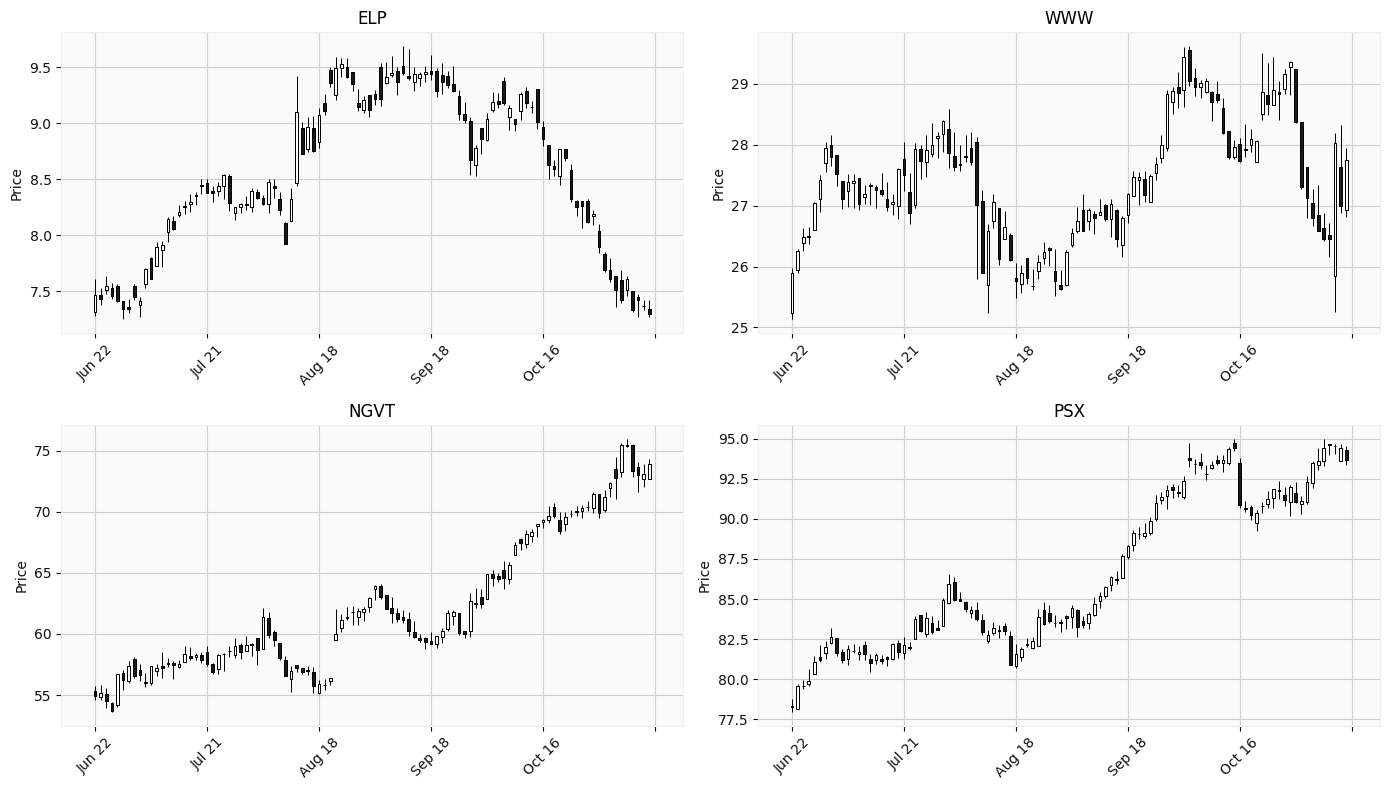

Candlestick chart of a few random ETFs:


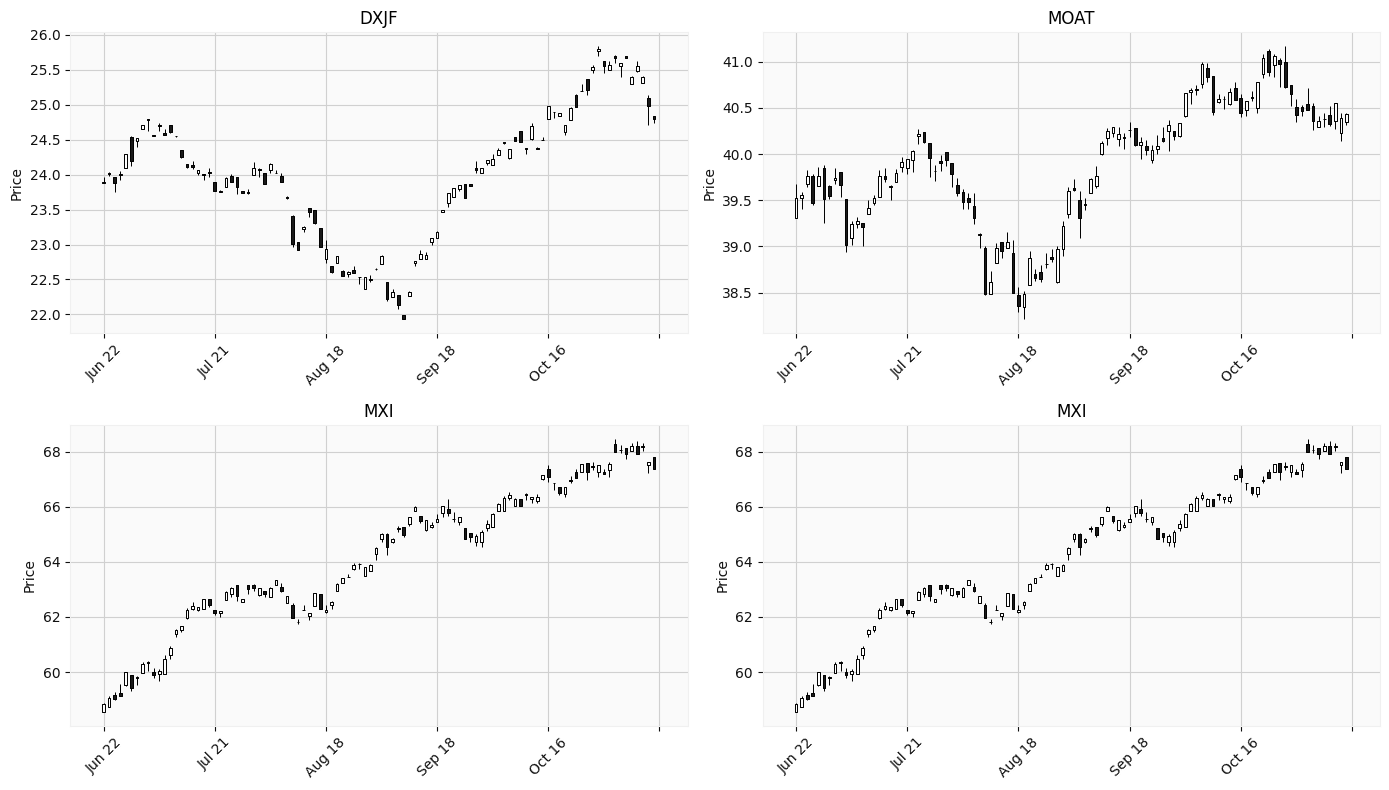

In [22]:
NRAND = 4
NDAYS = 100
print("Candlestick chart of a few random stocks:")
binfo_stock.plot_random_assets(NRAND, NDAYS)
print("Candlestick chart of a few random ETFs:")
binfo_etf.plot_random_assets(NRAND, NDAYS)

Plot of a few random stocks with EMA, Bollinger Bands, MACD and RSI


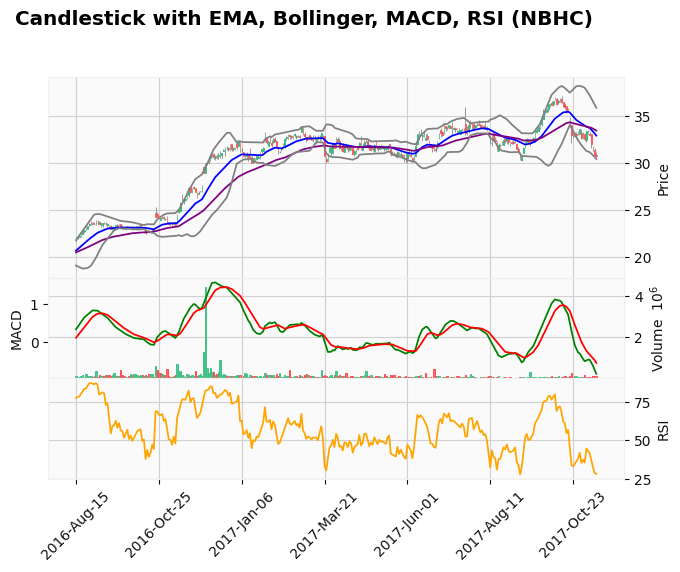

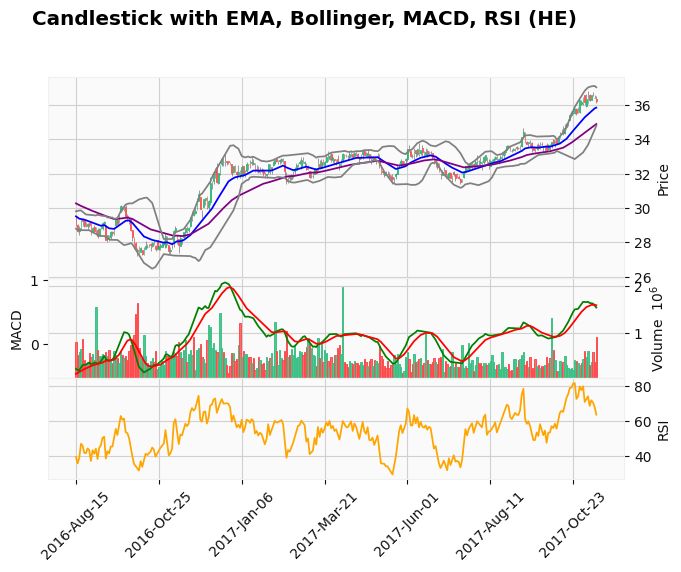

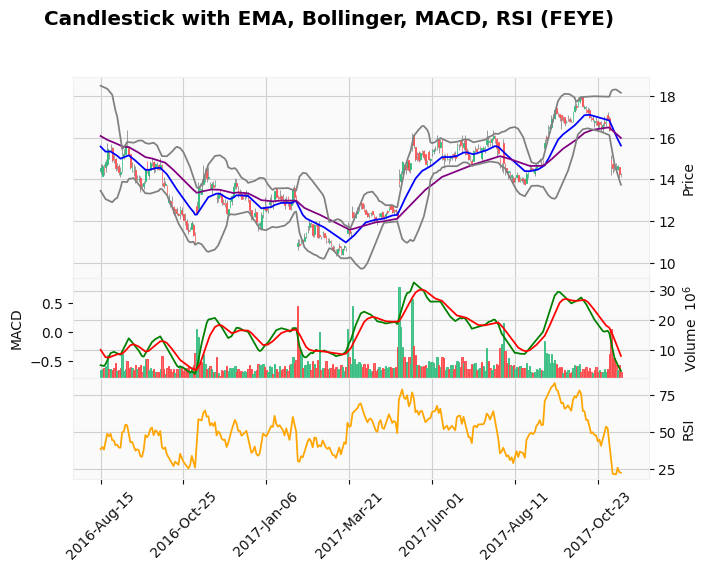

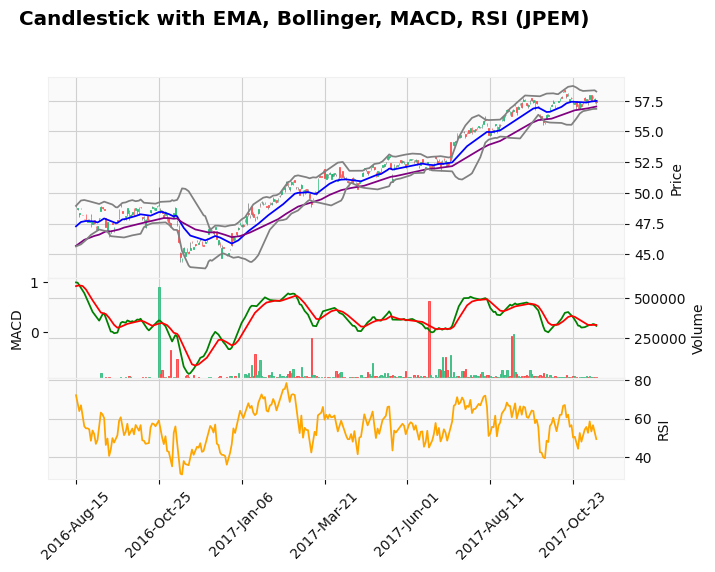

In [23]:
print("Plot of a few random stocks with EMA, Bollinger Bands, MACD and RSI")
YEAR = 365
binfo_stock.plot_common_ta_indicators(NRAND, YEAR)

Plot of a few random ETFs with EMA, Bollinger Bands, MACD and RSI


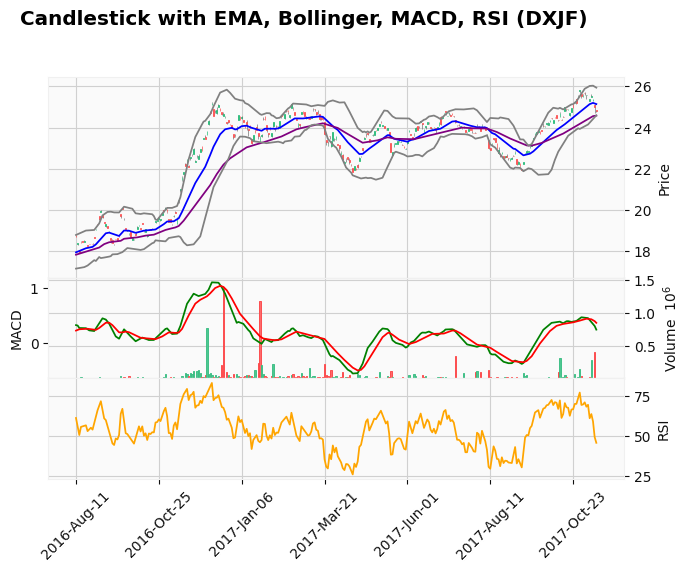

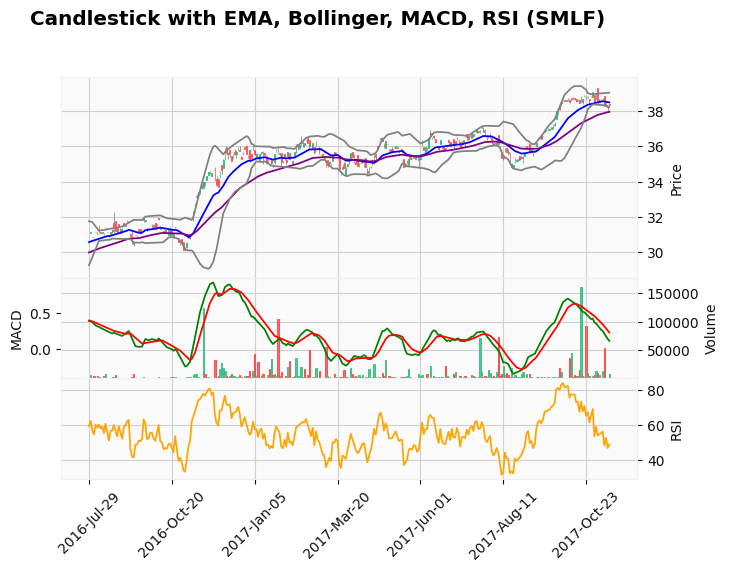

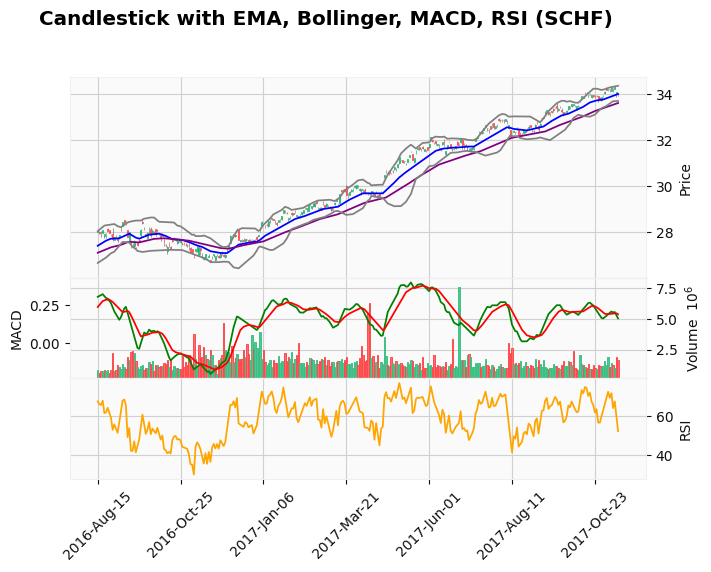

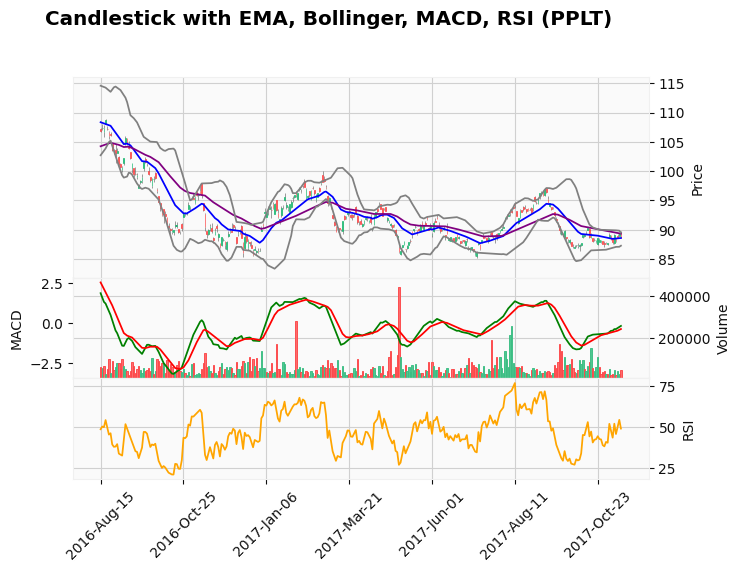

In [24]:
print("Plot of a few random ETFs with EMA, Bollinger Bands, MACD and RSI")
binfo_etf.plot_common_ta_indicators(NRAND, YEAR)

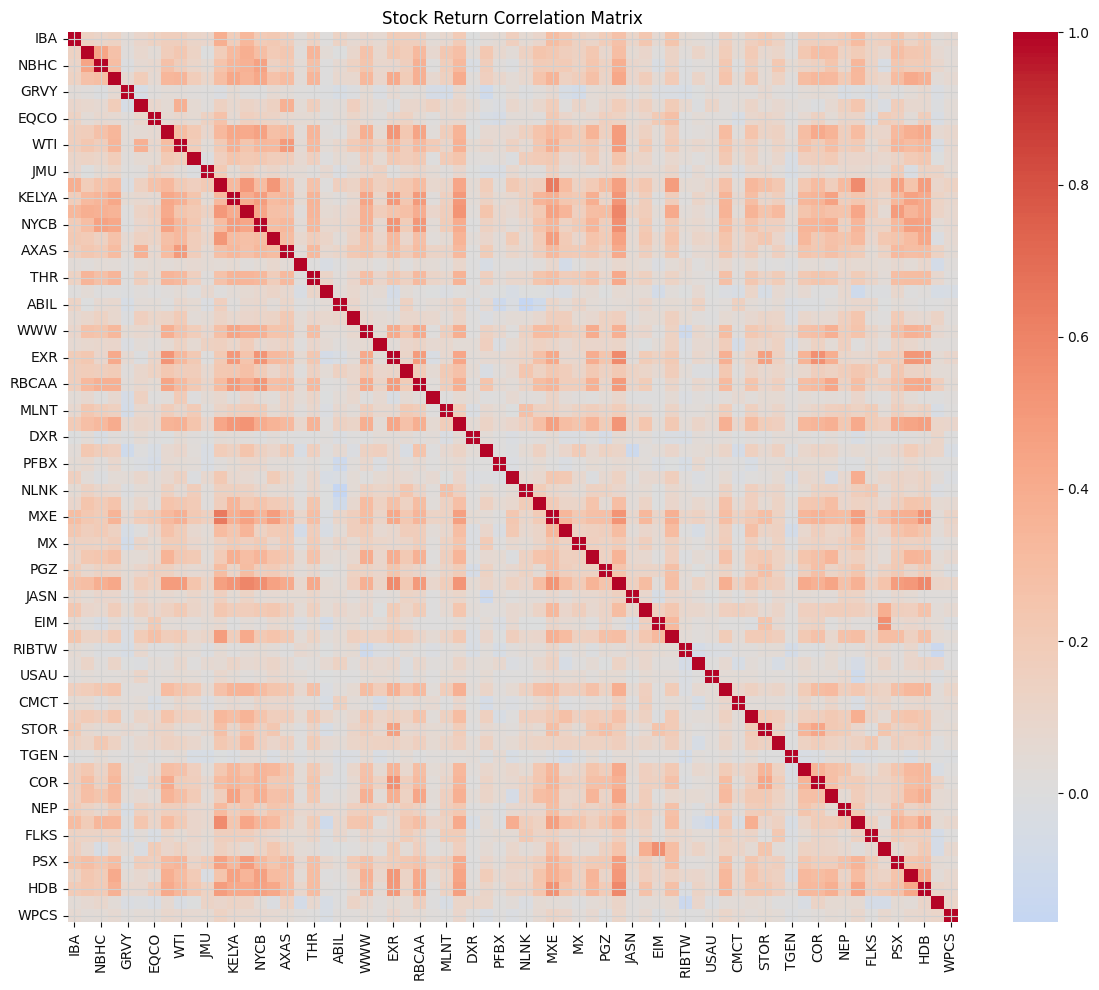

In [25]:
binfo_stock.corr_mtx()

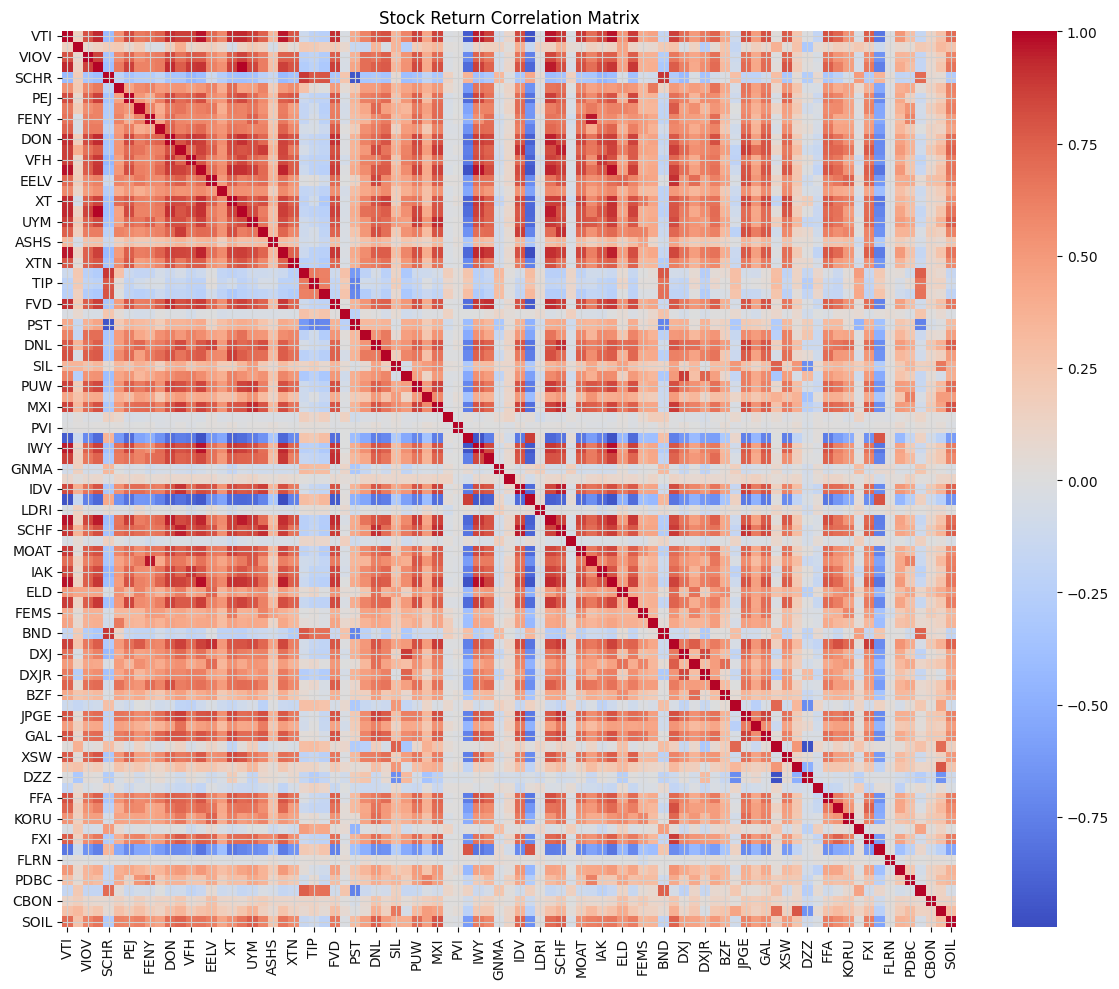

In [26]:
binfo_etf.corr_mtx()

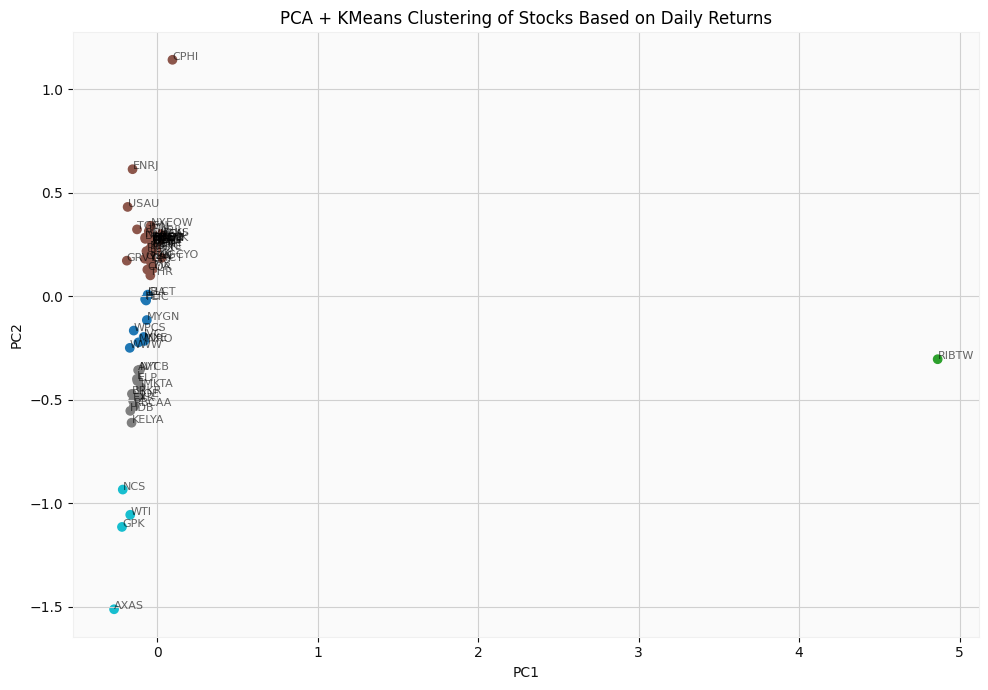

In [27]:
binfo_stock.kmeans()

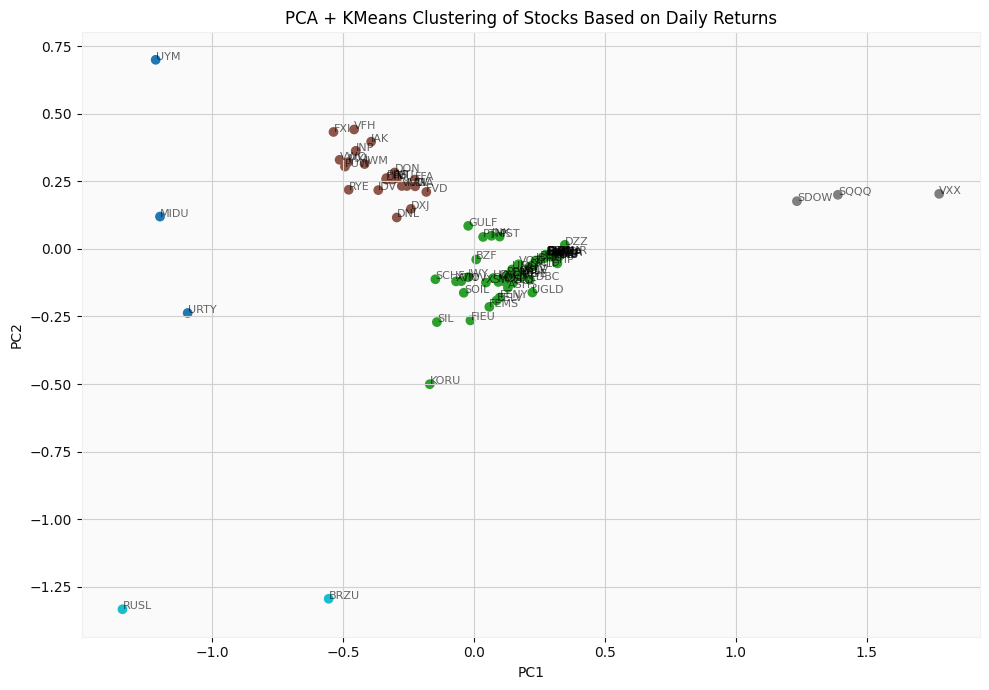

In [28]:
binfo_etf.kmeans()